<a href="https://colab.research.google.com/github/quantbrasil/youtube/blob/master/src/007_Crypto_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto Data Analysis

In this tutorial, we'll learn how to:

1. Fetch cryptocurrency price data from Coinbase API
2. Process and clean the data with pandas
3. Resample data to different timeframes
4. Visualize cryptocurrency price movements

## 1. Setting Up Our Environment

First, let's import the necessary libraries:

In [19]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Setting for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

## 2. Understanding the Coinbase API

The Coinbase API is a powerful tool for accessing cryptocurrency market data. In this tutorial, we'll focus on the candle data endpoint, which provides OHLCV (Open, High, Low, Close, Volume) data for various cryptocurrencies.

**API Reference**: https://docs.cloud.coinbase.com/exchange/reference/exchangerestapi_getproductcandles

### Key Parameters for Candle Data:
- `product_id`: The trading pair (e.g., "BTC-USD")
- `start`: Start date/time in ISO format
- `end`: End date/time in ISO format
- `granularity`: Time interval in seconds (e.g., 60 for 1-minute candles)

### Available Granularities (in seconds):
- 60 = 1 minute
- 300 = 5 minutes
- 900 = 15 minutes
- 3600 = 1 hour
- 21600 = 6 hours
- 86400 = 1 day

## 3. Fetching Cryptocurrency Data

Now, let's create a function to fetch cryptocurrency data from the Coinbase API:

In [20]:
# List of popular crypto tickers
crypto_tickers = [
    "BTC-USD",  # Bitcoin
    "ETH-USD",  # Ethereum
    "SOL-USD",  # Solana
    "ADA-USD",  # Cardano
    "AVAX-USD", # Avalanche
    "MATIC-USD" # Polygon
]

# Mapping between timeframe IDs and granularities
def map_to_granularity(timeframe_id):
    """Convert a timeframe ID to granularity in seconds."""
    if timeframe_id in ["M15", "M30"]:
        return 900  # 15 minutes
    if timeframe_id in ["H1", "H2", "H4"]:
        return 3600  # 1 hour
    if timeframe_id in ["D1", "W1"]:
        return 86400  # 1 day
    
    print("Timeframe id not found, defaulting to D1...")
    return 86400

def fetch_crypto_data(product_id, timeframe_id, start_date, end_date):
    """Fetch cryptocurrency data from Coinbase API.
    
    Args:
        product_id (str): Trading pair, e.g., "BTC-USD"
        timeframe_id (str): Timeframe ID, e.g., "D1", "H1", "M15"
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        
    Returns:
        pandas.DataFrame: OHLCV data
    """
    # Map the timeframe ID to granularity in seconds
    granularity = map_to_granularity(timeframe_id)
    
    # Coinbase API endpoint for candle data
    url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"
    
    # Delta is the increment in time from one candle to another
    delta = timedelta(seconds=granularity)
    
    # Coinbase's limitation: max 300 candles per request
    max_candles = 300
    
    # Parse start and end dates
    # Start from the last second of last day to prevent duplications
    current_date = datetime.strptime(start_date, "%Y-%m-%d") - timedelta(seconds=1)
    
    # Make sure end date is at the last second of the day
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(
        seconds=59, minutes=59, hours=23
    )
    
    results = []
    
    # Loop through time periods to get all data (handling API limits)
    while current_date < end_date_obj:
        # Calculate next date window (limited by max_candles)
        next_date = current_date + max_candles * delta
        next_date = min(next_date, end_date_obj)
        
        # API request parameters
        params = {
            "start": current_date.isoformat(),
            "end": next_date.isoformat(),
            "granularity": granularity,
        }
        
        headers = {"content-type": "application/json"}
        
        # Make the API request
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        
        # Coinbase returns data in reverse chronological order (newest first)
        # We prepend to maintain this order
        results = data + results
        
        # Update the current date for the next iteration
        current_date = next_date
    
    # Convert results to a DataFrame
    df = pd.DataFrame(
        data=results,
        columns=[
            "timestamp",
            "low",
            "high",
            "open",
            "close",
            "volume",
        ],
    )
    
    # Convert timestamp to datetime and set as index
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
    df.set_index("datetime", inplace=True)
    
    # Sort by datetime (oldest first)
    df = df.sort_index()
    
    return df

## 4. Fetching Example Data

Let's fetch Bitcoin daily data for the past 6 months as an example:

In [21]:
days = 180

# Calculate date range
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d")

# Fetch Bitcoin daily data
btc_daily = fetch_crypto_data("BTC-USD", "D1", start_date, end_date)

# Display the first few rows
print(f"Fetched {len(btc_daily)} days of Bitcoin data from {start_date} to {end_date}")
btc_daily.tail()

Fetched 181 days of Bitcoin data from 2024-11-10 to 2025-05-09


,timestamp,low,high,open,close,volume
datetime,,,,,,
2025-05-05,1746403200,93500.01,95218.82,94272.54,94733.99,5180.158939
2025-05-06,1746489600,93363.28,96916.25,94733.99,96839.17,6163.867558
2025-05-07,1746576000,95800.00,97738.05,96843.84,97058.32,8326.908828
2025-05-08,1746662400,96888.25,104176.05,97058.33,103253.49,15378.085135
2025-05-09,1746748800,102330.76,104352.60,103252.20,103370.65,6955.399412


## 5. Data Exploration

Let's explore the Bitcoin data:

In [22]:
# Basic statistics
btc_daily.describe()

,timestamp,low,high,open,close,volume
count,1.810000e+02,181.000000,181.000000,181.000000,181.000000,181.000000
mean,1.738973e+09,91131.786354,95007.159558,93068.182762,93212.340608,12035.877224
std,4.526871e+06,7172.243475,7092.253668,7154.897495,7092.786886,8276.498097
min,1.731197e+09,74420.690000,80849.980000,76258.800000,76251.640000,261.499228
25%,1.735085e+09,84353.450000,88530.000000,86206.640000,86756.980000,5979.425212
50%,1.738973e+09,93333.000000,96430.080000,94733.990000,94764.560000,10582.846228
75%,1.742861e+09,96105.110000,99444.000000,97762.750000,97778.770000,16587.286922
max,1.746749e+09,105337.970000,109358.010000,106159.270000,106159.260000,42318.690917


In [23]:
# Calculate daily returns
btc_daily['daily_return'] = btc_daily['close'].pct_change() * 100

# Display daily returns statistics
btc_daily['daily_return'].describe()

count    180.000000
mean       0.176595
std        2.741070
min       -8.597400
25%       -1.201483
50%        0.051151
75%        1.290974
max       10.371655
Name: daily_return, dtype: float64

## 6. Visualizing the Data

Let's create some visualizations to understand the Bitcoin price movements:

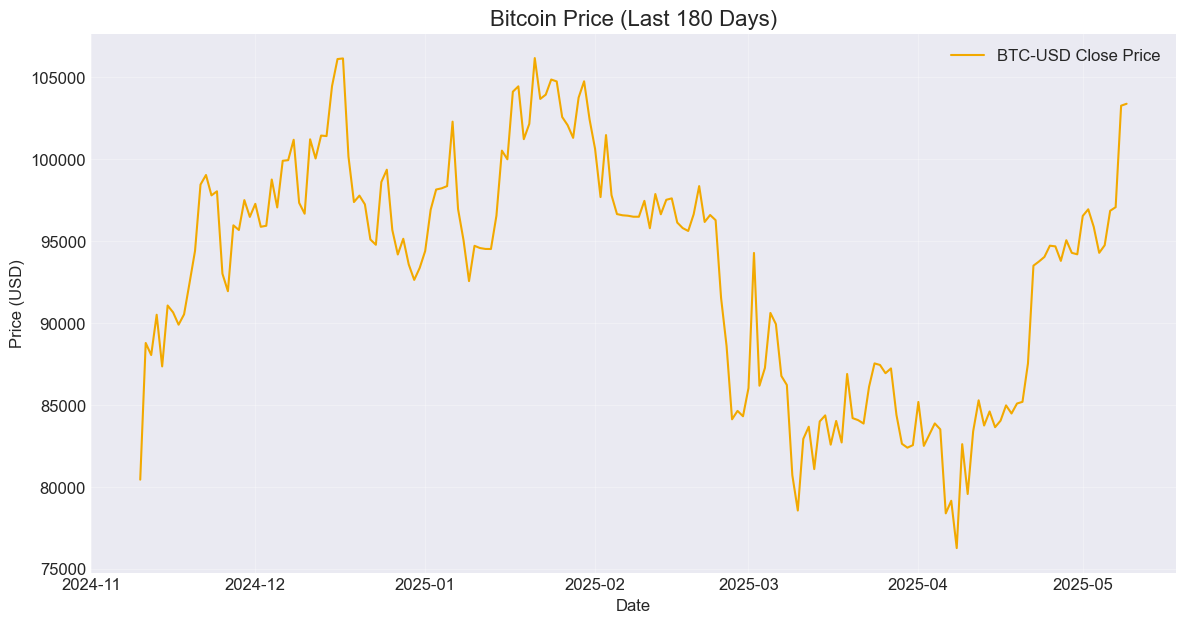

In [24]:
# Plot Bitcoin price
plt.figure(figsize=(14, 7))
plt.plot(btc_daily.index, btc_daily['close'], label='BTC-USD Close Price', color='#f2a900')
plt.title(f'Bitcoin Price (Last {days} Days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

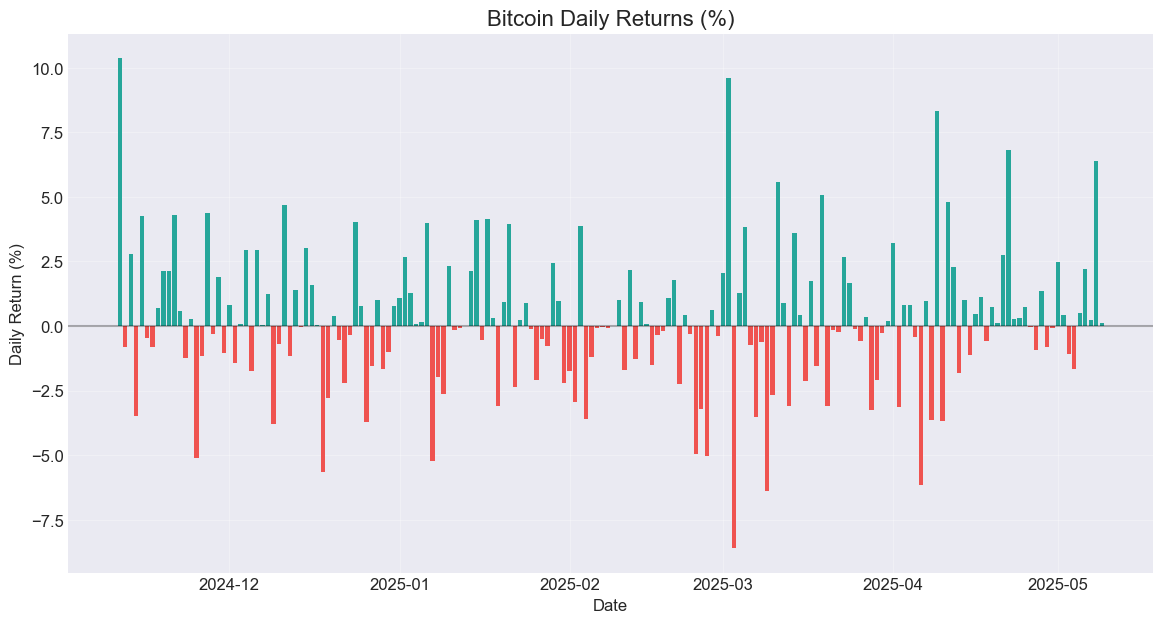

In [25]:
# Plot daily returns
plt.figure(figsize=(14, 7))
plt.bar(btc_daily.index, btc_daily['daily_return'], color=np.where(btc_daily['daily_return'] > 0, '#26a69a', '#ef5350'))
plt.title('Bitcoin Daily Returns (%)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.show()

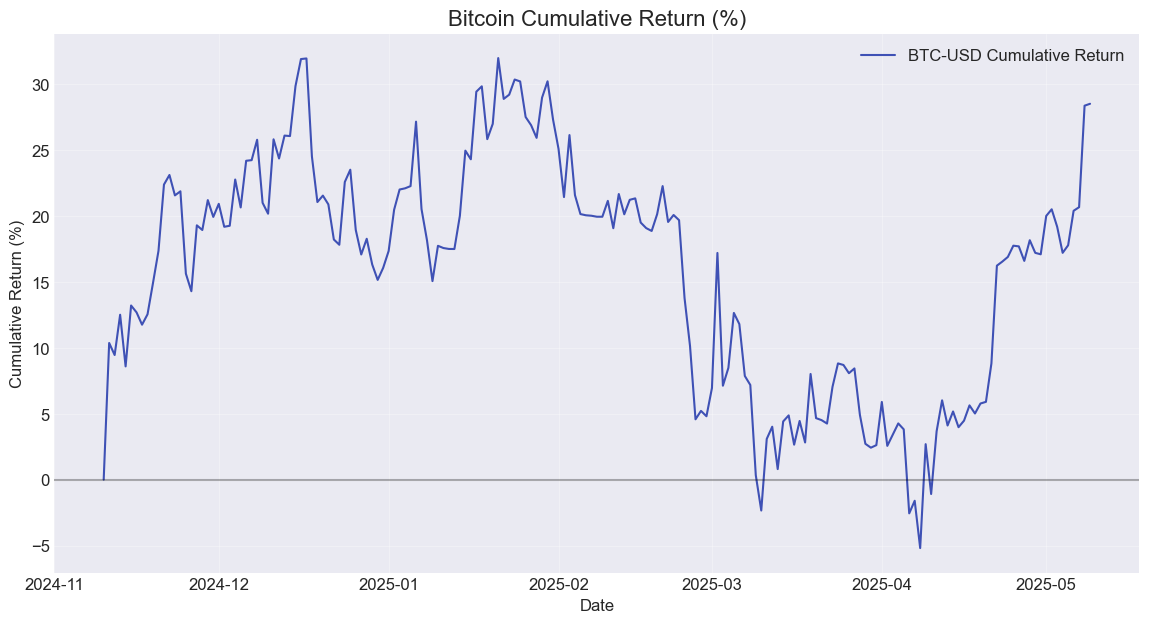

In [26]:
# Plot cumulative returns
# Create a copy of the dataframe to avoid modifying the original
btc_daily_returns = btc_daily.copy()

# Replace the first NaN value with 0 to ensure the cumulative return starts at 0
btc_daily_returns.loc[btc_daily_returns.index[0], 'daily_return'] = 0

# Calculate cumulative returns
btc_daily_returns['cumulative_return'] = (1 + btc_daily_returns['daily_return']/100).cumprod() - 1

plt.figure(figsize=(14, 7))
plt.plot(btc_daily_returns.index, btc_daily_returns['cumulative_return'] * 100, label='BTC-USD Cumulative Return', color='#3f51b5')
plt.title('Bitcoin Cumulative Return (%)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.show()

## 7. Resampling Data to Different Timeframes

One of the key skills in quantitative analysis is resampling data to different timeframes. Let's see how to do this with the Bitcoin data:

In [27]:
def resample_ohlcv(df, timeframe):
    """Resample OHLCV data to a different timeframe.
    
    Args:
        df (pandas.DataFrame): Original OHLCV data
        timeframe (str): Target timeframe (pandas resample rule)
        
    Returns:
        pandas.DataFrame: Resampled OHLCV data
    """
    # Apply resampling with proper aggregation for each column
    resampled = df.resample(timeframe).agg({
        'open': 'first',    # First price in the period
        'high': 'max',      # Highest price in the period
        'low': 'min',       # Lowest price in the period
        'close': 'last',    # Last price in the period
        'volume': 'sum'     # Sum of volume in the period
    })
    
    # Drop any rows with NaN values
    return resampled.dropna()

In [28]:
# Let's create hourly data first (for demonstration)
# We'll fetch 14 days of hourly data
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=14)).strftime("%Y-%m-%d")

# Fetch Bitcoin hourly data
btc_hourly = fetch_crypto_data("BTC-USD", "H1", start_date, end_date)
print(f"Fetched {len(btc_hourly)} hours of Bitcoin data")

# Now resample to different timeframes
btc_4h = resample_ohlcv(btc_hourly, '4h')
btc_daily_from_hourly = resample_ohlcv(btc_hourly, 'D')

print(f"4-hour candles: {len(btc_4h)}")
print(f"Daily candles (from hourly): {len(btc_daily_from_hourly)}")

# Display the first few rows of the 4-hour data
btc_4h.tail(6)

Fetched 357 hours of Bitcoin data
4-hour candles: 90
Daily candles (from hourly): 15


,open,high,low,close,volume
datetime,,,,,
2025-05-09 00:00:00,103252.20,103262.94,102350.01,102433.37,846.916063
2025-05-09 04:00:00,102434.44,104352.60,102350.64,103659.95,908.923806
2025-05-09 08:00:00,103654.74,103953.31,102413.91,102942.84,954.605411
2025-05-09 12:00:00,102939.79,103799.48,102418.38,102909.00,2237.164979
2025-05-09 16:00:00,102909.02,103413.26,102330.76,103229.28,1893.695504
2025-05-09 20:00:00,103240.53,103449.99,103204.98,103370.65,114.093648


In [29]:
btc_daily_from_hourly.tail(1)

,open,high,low,close,volume
datetime,,,,,
2025-05-09,103252.2,104352.6,102330.76,103370.65,6955.399412


Let's compare our resampled daily data with the original daily data to verify the resampling works correctly:

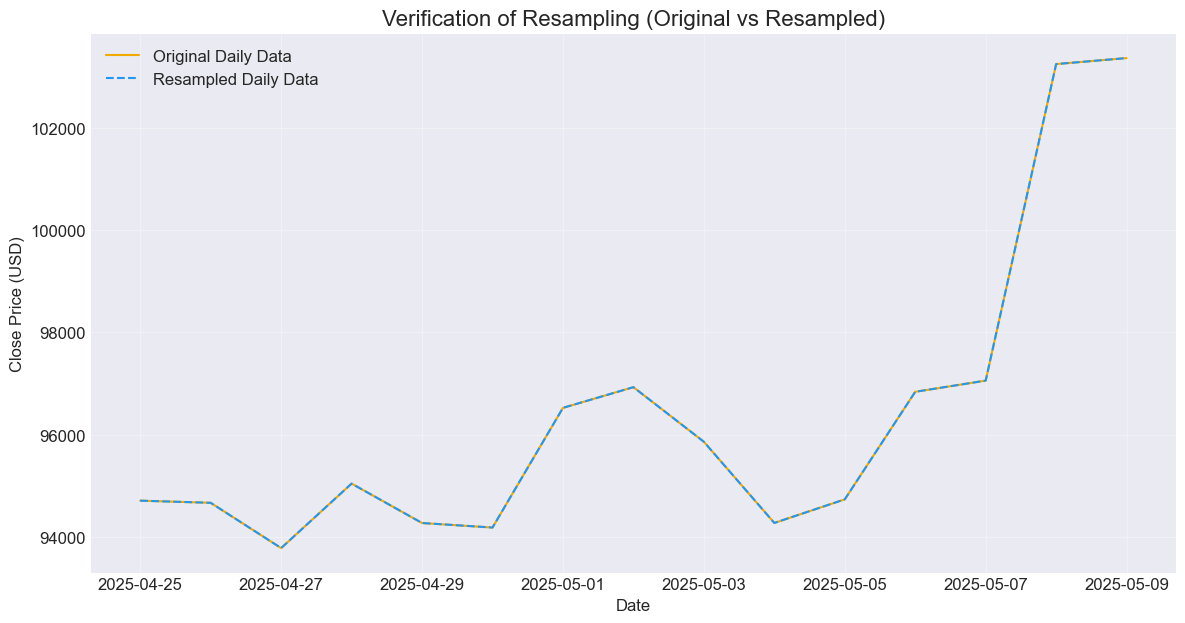

In [30]:
# Get the same date range from our original daily data
btc_daily_subset = btc_daily[btc_daily.index >= btc_daily_from_hourly.index[0]]

# Plot original daily data vs resampled daily data
plt.figure(figsize=(14, 7))
plt.plot(btc_daily_subset.index, btc_daily_subset['close'], label='Original Daily Data', color='#f2a900')
plt.plot(btc_daily_from_hourly.index, btc_daily_from_hourly['close'], label='Resampled Daily Data', 
         color='#2196f3', linestyle='--')

plt.title('Verification of Resampling (Original vs Resampled)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 8. Fetching and Comparing Multiple Cryptocurrencies

Let's fetch data for multiple cryptocurrencies and compare their performance:

In [31]:
# Define the cryptocurrencies to compare
crypto_compare = ["BTC-USD", "ETH-USD", "SOL-USD"]

# Date range (last 3 months)
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=90)).strftime("%Y-%m-%d")

# Fetch data for each cryptocurrency
crypto_data = {}
for crypto in crypto_compare:
    crypto_data[crypto] = fetch_crypto_data(crypto, "D1", start_date, end_date)
    print(f"Fetched {len(crypto_data[crypto])} days of {crypto} data")

Fetched 91 days of BTC-USD data
Fetched 91 days of ETH-USD data
Fetched 91 days of SOL-USD data


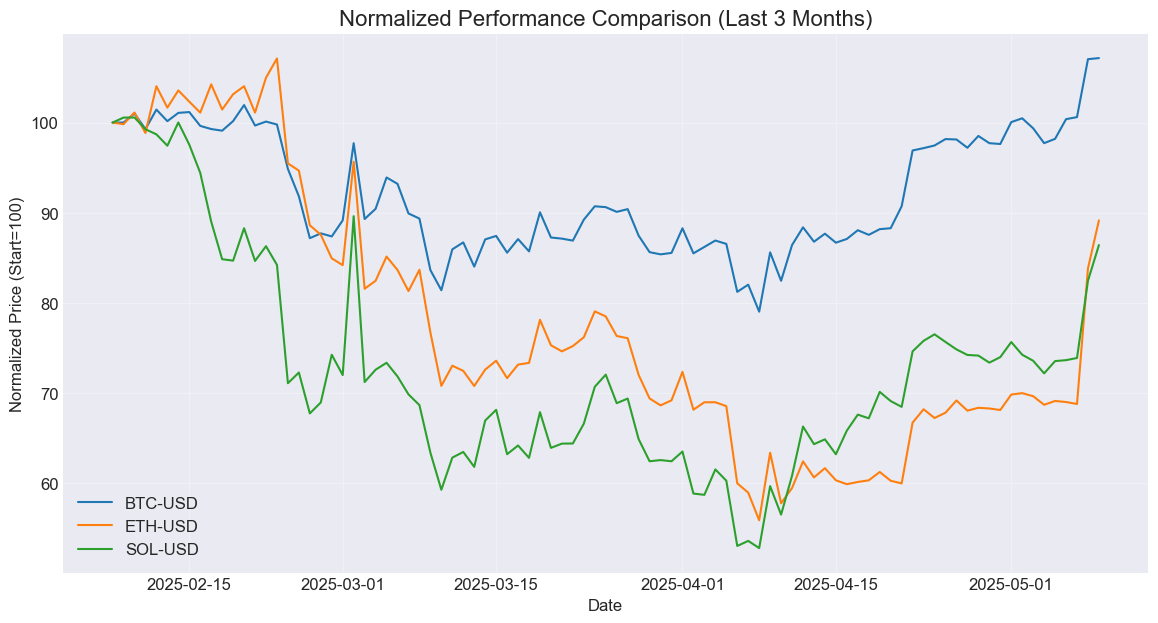

In [32]:
# Normalize prices for comparison (start at 100)
normalized_data = pd.DataFrame(index=crypto_data["BTC-USD"].index)

for crypto in crypto_compare:
    # Calculate normalized price (start at 100)
    first_price = crypto_data[crypto]['close'].iloc[0]
    normalized_data[crypto] = (crypto_data[crypto]['close'] / first_price) * 100

# Plot normalized prices
plt.figure(figsize=(14, 7))

for crypto in crypto_compare:
    plt.plot(normalized_data.index, normalized_data[crypto], label=crypto)

plt.title('Normalized Performance Comparison (Last 3 Months)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price (Start=100)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [33]:
# Calculate correlation matrix
returns_data = pd.DataFrame(index=crypto_data["BTC-USD"].index)

for crypto in crypto_compare:
    # Calculate daily returns
    returns_data[crypto] = crypto_data[crypto]['close'].pct_change()

# Remove first day (NaN)
returns_data = returns_data.dropna()

# Calculate and display correlation matrix
correlation_matrix = returns_data.corr()
print("Correlation Matrix of Daily Returns:")
correlation_matrix

Correlation Matrix of Daily Returns:


,BTC-USD,ETH-USD,SOL-USD
BTC-USD,1.000000,0.873119,0.862157
ETH-USD,0.873119,1.000000,0.832572
SOL-USD,0.862157,0.832572,1.000000


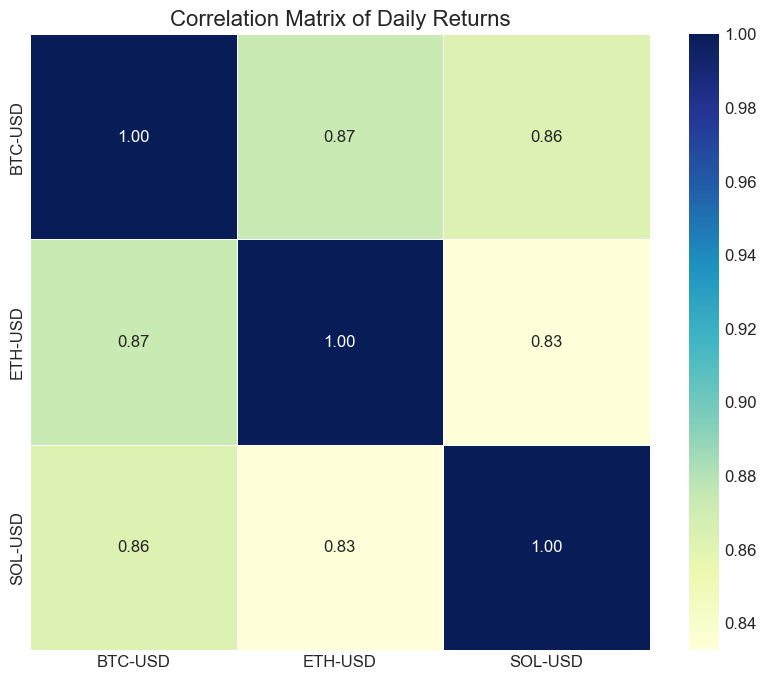

In [34]:
# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.show()